Dataset: https://www.kaggle.com/iabhishekofficial/mobile-price-classification

# Problem Framing

Here we want to know the general specifications of mobile phones in a certain price range. We will be using supervised classification because we already have the label (price range), but we will not be using overly complex models because the end goal is the interpretability of the model, and complex models generally have low interpretability.

We will be prioritizing accuracy score because we want the model to make as close a prediction as possible to the true value, so that we can interpret the model accurately.

# EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_mobile = pd.read_csv('Mobile Price Classification.csv')

In [3]:
df_mobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Here we can see that:
- the dataset contains no null values
- all the data format is already in integer or float, as they're supposed to be

In [4]:
df_mobile.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


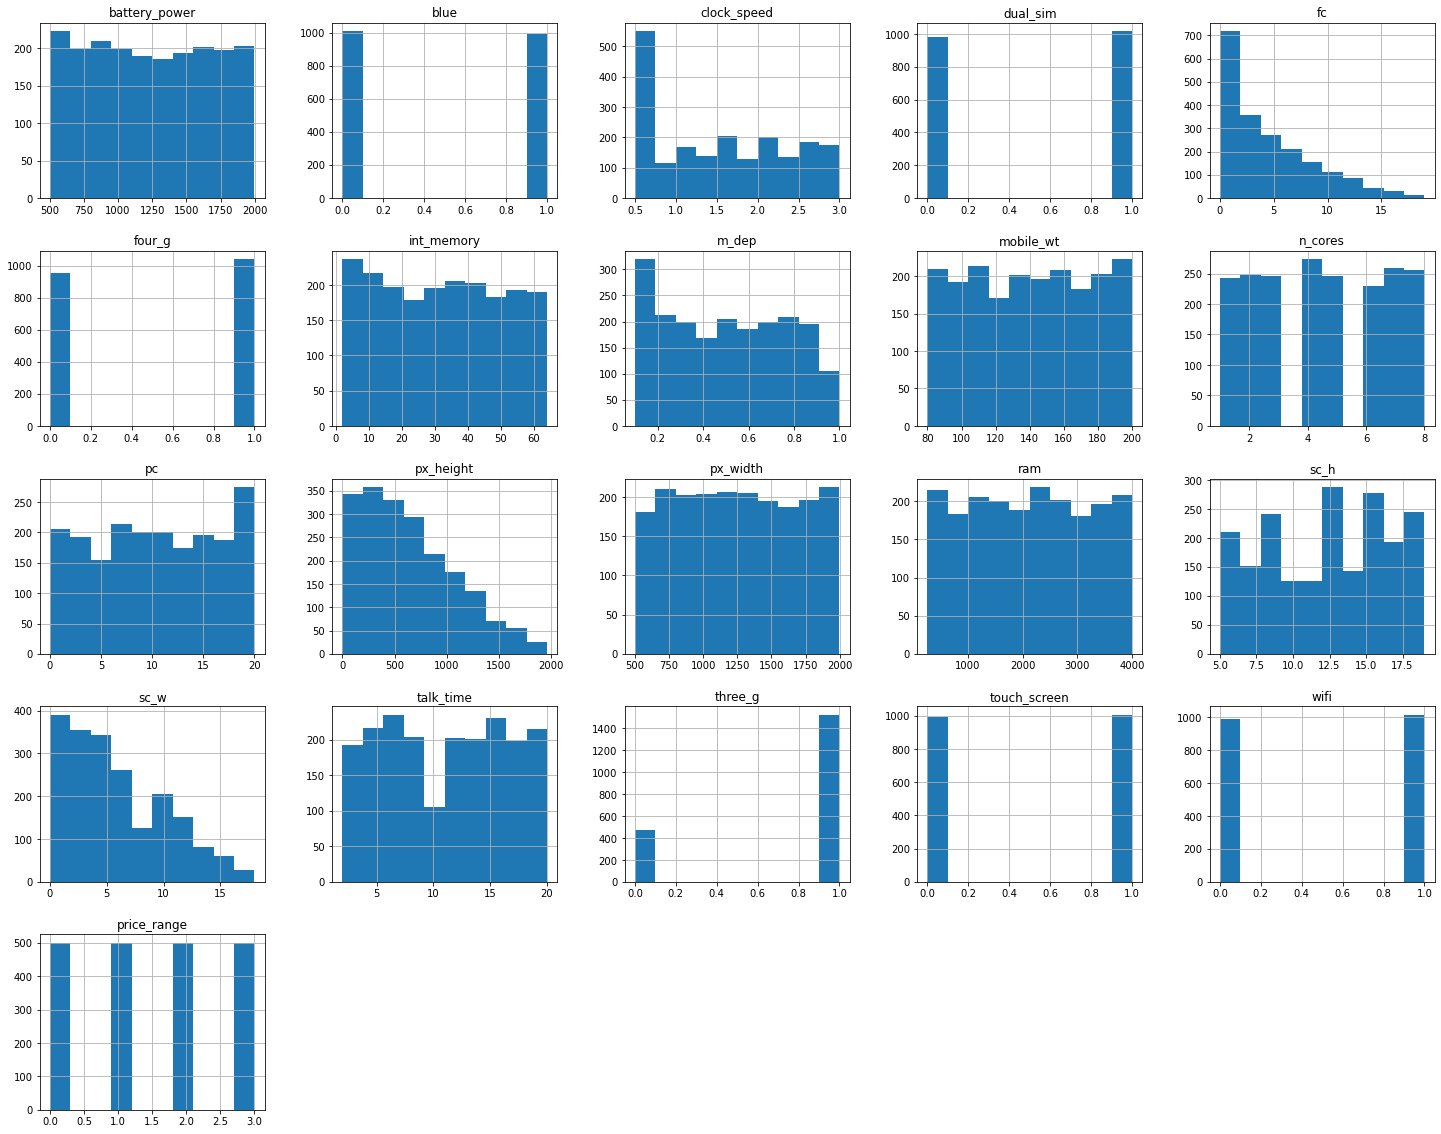

In [7]:
df_mobile.hist(figsize=(25,20));

The numerical distribution are not in the same scale (e.g. battery_power is in 1000s, while m_dep is less than 1.0) so we need to perform scaling to the numerical columns.

categorical columns:
'blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi'

We are going to be using all variable as features because the goal of the analysis is to find out which variables define each price_range

We want to see the distribution of each variable. The variables that are non-uniform and non-normally distributed are:
- clock_speed, fc, px_height, sc_w, and three_g

When doing train-test split, it's best to stratify these variables to keep things balanced.

but fc, px_height only have 1 datapoint in the least populated group, so they cannot be stratified. And the combination of clock_speed, sc_w, and three_g produces groups that contains 1 datapoint so they cannot be used as well. Therefore we are only using the variables clock_speed and three_g to stratify.

In [43]:
df_mobile.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

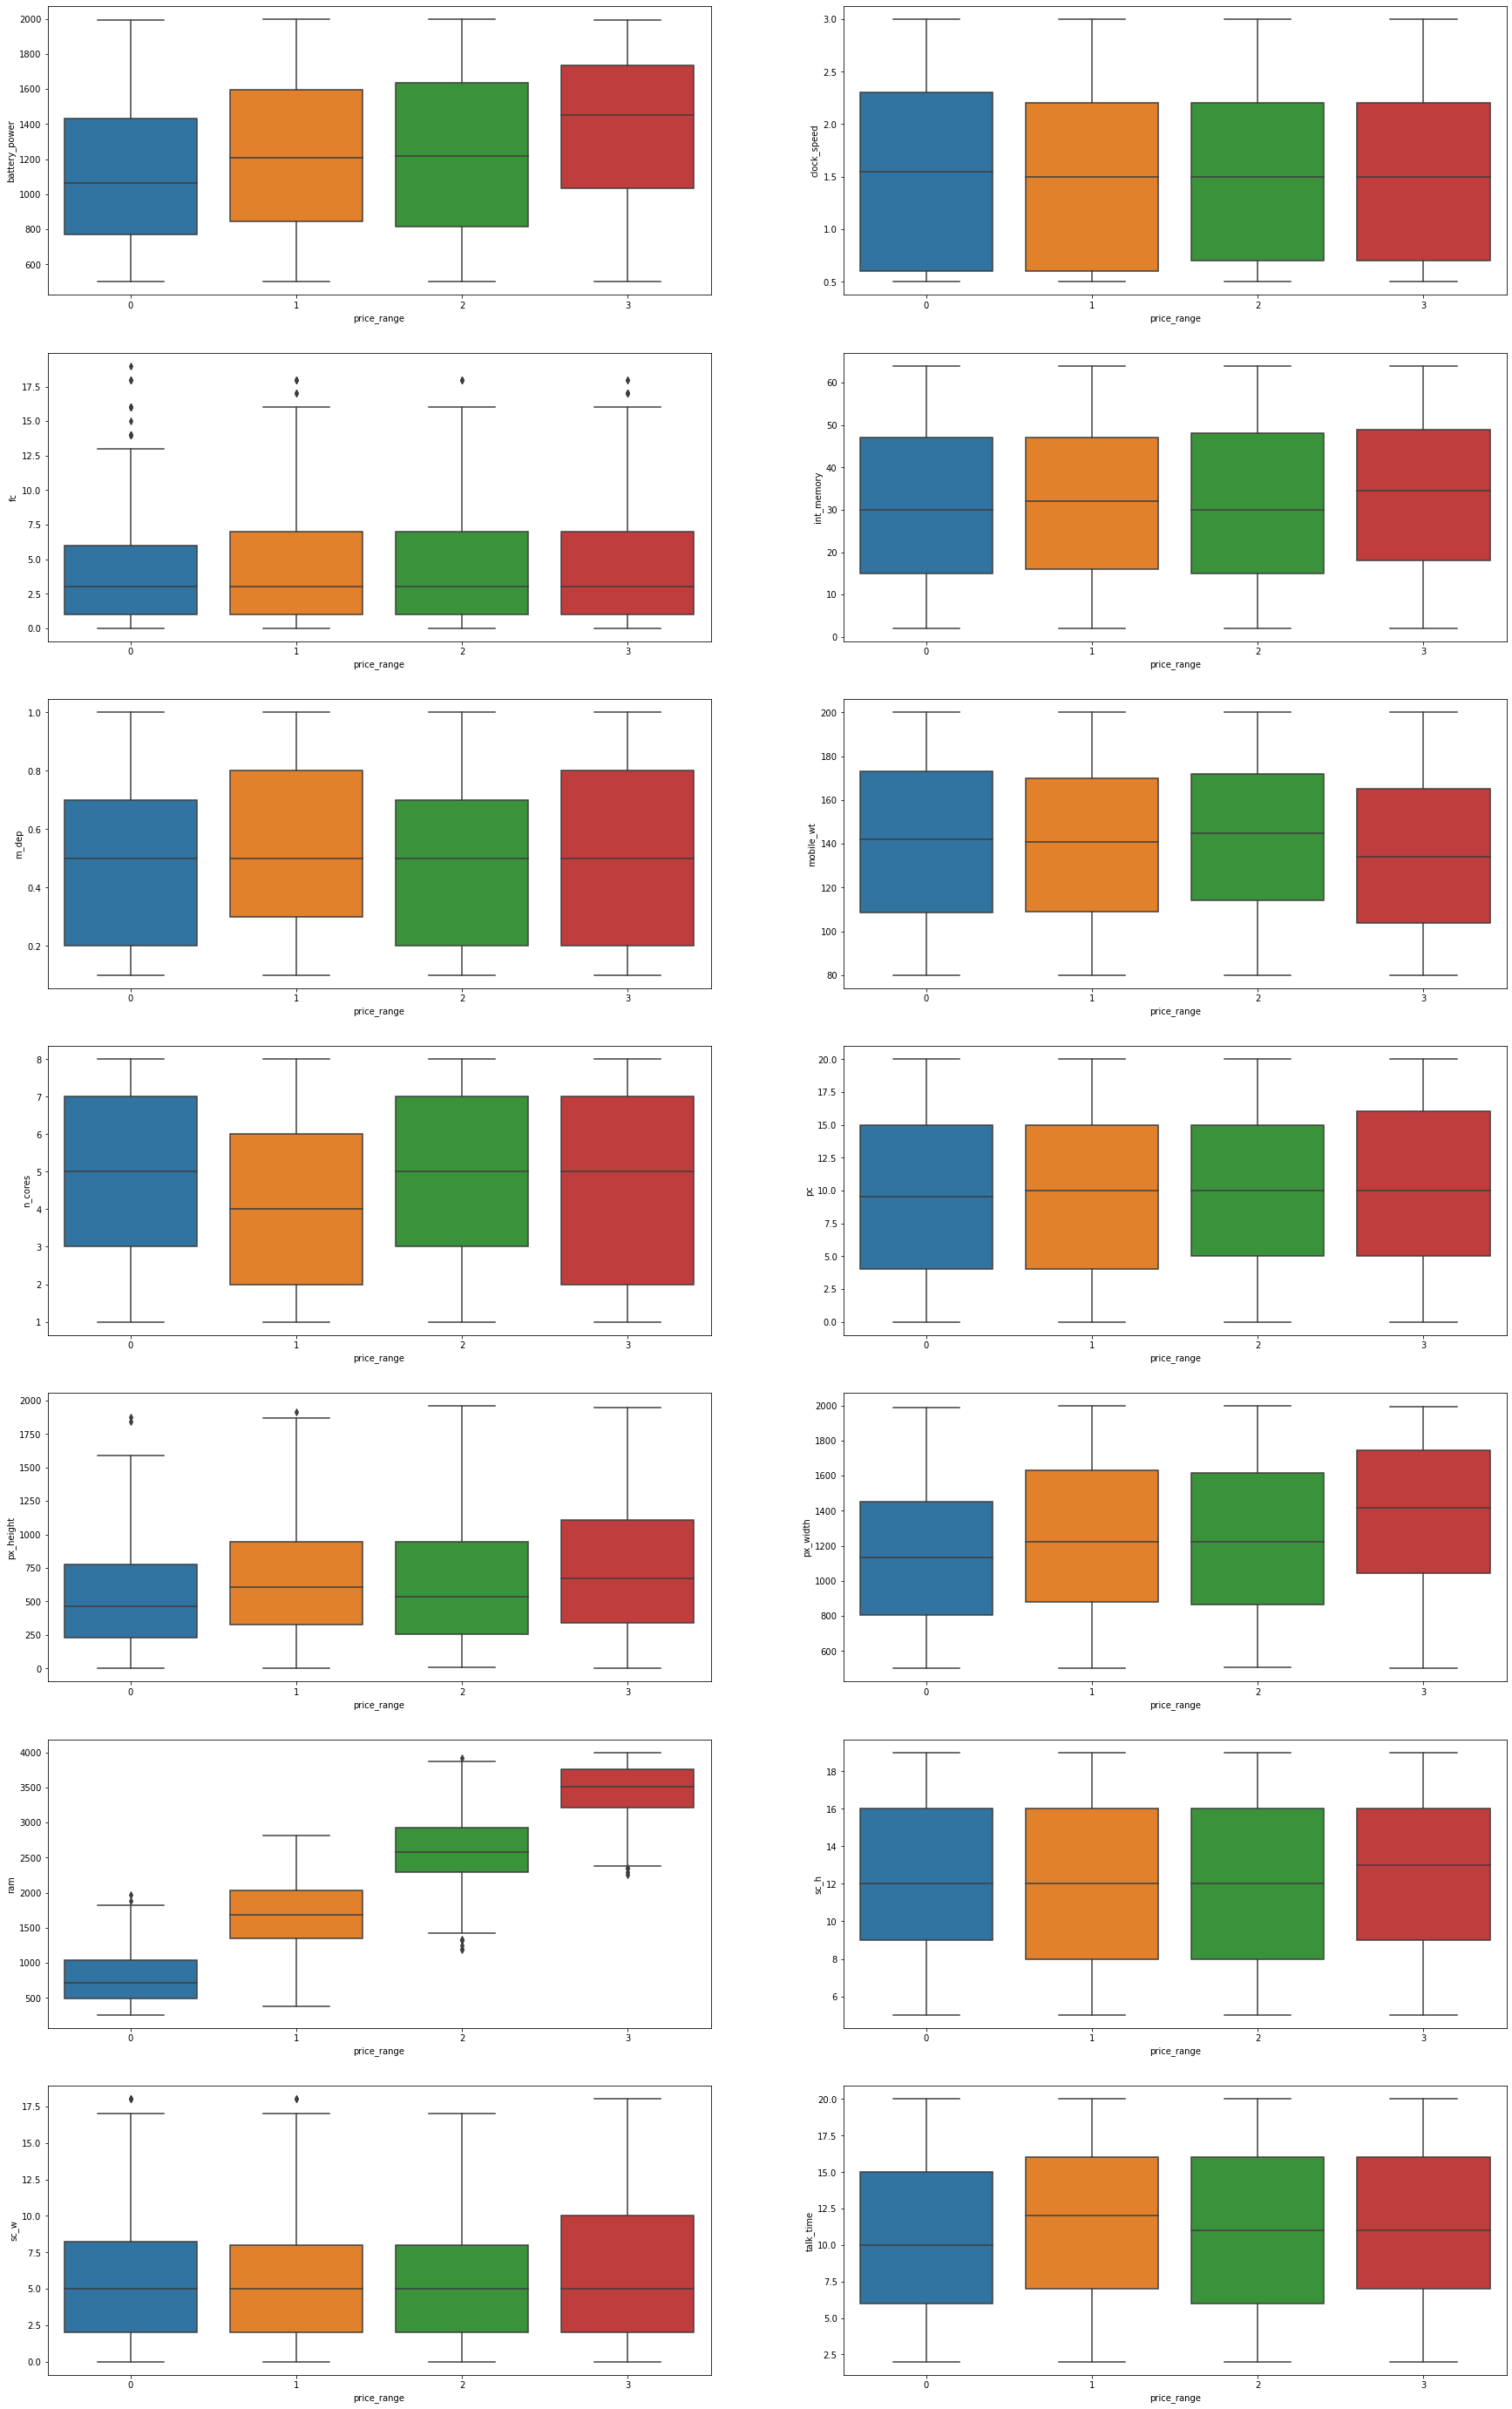

In [200]:
fig, axes = plt.subplots(7, 2, figsize=(30,50))
for ix, var in enumerate(['battery_power', 'clock_speed', 'fc',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']):
    sns.boxplot(y=var, x='price_range', data=df_mobile, ax=axes.flatten()[ix])

plt.savefig('mobile_boxplot.png')

From the boxplot, we can make a preliminary hypothesis that the most differing feature between price ranges is the ram. We can also try to predict that fc, clock_speed, and pc have little to no impact to the price range.

In [268]:
label = 'price_range'

X = df_mobile.drop([label], axis=1)
y = df_mobile[label]

In [269]:
# train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=X[['clock_speed', 'three_g']])

# Make Pipelines for Data Preparation and Model Selection

In [274]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# some columns need to be scaled using robust scaler because they don't have normal distribution
ctg_cols = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
num_cols = ['battery_power', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc','px_width', 'ram',
            'talk_time', 'clock_speed', 'fc', 'px_height', 'sc_h', 'sc_w']

# use dummy transformer for unprocessed columns to be detected by the ColumnTransformer or Pipeline
class DoNothingTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.values

# column transformer containing preprocessing steps
col_trf_preprocess = ColumnTransformer([
    ('std_scaler', StandardScaler(), num_cols),
    ('skip', DoNothingTransformer(), ctg_cols)
])

# pipeline for logistic regression model
pipeline_log_reg = Pipeline([
    ('col_trf', col_trf_preprocess),
    ('log_reg', LogisticRegression(multi_class='multinomial'))
])

# pipeline for decision tree
pipeline_dt = Pipeline([
    ('col_trf', col_trf_preprocess),
    ('dt', DecisionTreeClassifier(random_state=10))
])

# pipeline for knn model
pipeline_knn = Pipeline([
    ('col_trf', col_trf_preprocess),
    ('knn', KNeighborsClassifier())
])

# Model Training, Evaluation

In [271]:
X_test.shape

(400, 20)

In [275]:
# check the models' performance
from sklearn.metrics import precision_score, recall_score

for estimator in [pipeline_log_reg, pipeline_dt, pipeline_knn]:
    estimator.fit(X_train, y_train)
    y_test_pred = estimator.predict(X_test)
    print('===========================')
    print(estimator[-1].__class__.__name__)
    print('Train Accuracy: {:.3f}'.format(estimator.score(X_train, y_train)))
    print('Train Accuracy: {:.3f}'.format(estimator.score(X_test, y_test)))
    print('Precision: {:.3f}'.format(precision_score(y_test, y_test_pred, average='micro')))
    print('Recall: {:.3f}'.format(recall_score(y_test, y_test_pred, average='micro')))

# try log reg without scaling
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('===========================')
print('LogisticRegression Without Scaling')
print('Train Accuracy: {:.3f}'.format(log_reg.score(X_train, y_train)))
print('Train Accuracy: {:.3f}'.format(log_reg.score(X_test, y_test)))
print('Precision: {:.3f}'.format(precision_score(y_test, y_test_pred, average='micro')))
print('Recall: {:.3f}'.format(recall_score(y_test, y_test_pred, average='micro')))

LogisticRegression
Train Accuracy: 0.978
Train Accuracy: 0.948
Precision: 0.948
Recall: 0.948
DecisionTreeClassifier
Train Accuracy: 1.000
Train Accuracy: 0.838
Precision: 0.838
Recall: 0.838
KNeighborsClassifier
Train Accuracy: 0.759
Train Accuracy: 0.605
Precision: 0.605
Recall: 0.605
LogisticRegression Without Scaling
Train Accuracy: 0.635
Train Accuracy: 0.650
Precision: 0.650
Recall: 0.650


C:\Users\sulis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [280]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import make_scorer

# initialize precision score calculator for multinomial classification
precision_scorer = make_scorer(precision_score, average='micro')
recall_scorer = make_scorer(recall_score, average='micro')

# cross_val_score(pipeline_log_reg, X_train, y_train, scoring=precision_scorer)
df_result = pd.DataFrame()

for regressor in [pipeline_log_reg, pipeline_dt, pipeline_knn]:
    df_result = df_result.append({
        'model': list(regressor.named_steps.keys())[-1],
        'accuracy': cross_val_score(regressor, X_train, y_train, cv=5, scoring='accuracy').mean(),
        'precision': cross_val_score(regressor, X_train, y_train, cv=5, scoring=precision_scorer).mean(),
        'recall': cross_val_score(regressor, X_train, y_train, cv=5, scoring=recall_scorer).mean()
    }, ignore_index=True)

In [281]:
df_result

,model,accuracy,precision,recall
0,log_reg,0.957500,0.957500,0.957500
1,dt,0.825625,0.825625,0.825625
2,knn,0.591250,0.591250,0.591250


In [285]:
df_cv_log_reg = pd.DataFrame(cross_validate(pipeline_log_reg, X_train, y_train, cv=5,
                           scoring=precision_scorer,
                          return_train_score=True))

df_cv_dt = pd.DataFrame(cross_validate(pipeline_dt, X_train, y_train, cv=5,
                           scoring=precision_scorer,
                          return_train_score=True))

df_cv_knn = pd.DataFrame(cross_validate(pipeline_knn, X_train, y_train, cv=5,
                           scoring=precision_scorer,
                          return_train_score=True))

In [282]:
df_cv_log_reg['model'] = 'log_reg'
df_cv_dt['model'] = 'dt'
df_cv_knn['model'] = 'knn'

In [288]:
log_reg_cv = []
dt_cv = []
knn_cv = []

for metric in ['fit_time', 'score_time', 'test_score', 'train_score']:
    log_reg_cv.append(df_cv_log_reg[metric].mean())
    dt_cv.append(df_cv_dt[metric].mean())
    knn_cv.append(df_cv_knn[metric].mean())

In [298]:
pd.DataFrame(data=np.array([log_reg_cv + dt_cv + knn_cv]).reshape(3, 4), columns=['fit_time', 'score_time', 'test_score', 'train_score'])

,fit_time,score_time,test_score,train_score
0,0.046475,0.003990,0.957500,0.978125
1,0.011564,0.003603,0.825625,1.000000
2,0.005192,0.017948,0.591250,0.745937


From the results above, we can see that Logistic Regression has the best performance in terms of accuracy, but also in precision and recall score as well. For that reason, we are using the Logistic Regression model and will try to tune the hyperparameter to see if we can get better results.

# Hyperparameter Tuning

In [190]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'log_reg__C': [0.3, 0.5, 1.0],
    'log_reg__solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
}

grid_search = GridSearchCV(pipeline_log_reg, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trf',
                                        ColumnTransformer(transformers=[('std_scaler',
                                                                         StandardScaler(),
                                                                         ['battery_power',
                                                                          'int_memory',
                                                                          'm_dep',
                                                                          'mobile_wt',
                                                                          'n_cores',
                                                                          'pc',
                                                                          'px_width',
                                                                          'ram',
                                                                       

In [191]:
pipeline_best = grid_search.best_estimator_
pipeline_best

Pipeline(steps=[('col_trf',
                 ColumnTransformer(transformers=[('std_scaler',
                                                  StandardScaler(),
                                                  ['battery_power',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_width', 'ram',
                                                   'talk_time', 'clock_speed',
                                                   'fc', 'px_height', 'sc_h',
                                                   'sc_w']),
                                                 ('skip',
                                                  DoNothingTransformer(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                      

## Retrain model using tuned hyperparameter

In [192]:
pipeline_best.fit(X_train, y_train)

Pipeline(steps=[('col_trf',
                 ColumnTransformer(transformers=[('std_scaler',
                                                  StandardScaler(),
                                                  ['battery_power',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_width', 'ram',
                                                   'talk_time', 'clock_speed',
                                                   'fc', 'px_height', 'sc_h',
                                                   'sc_w']),
                                                 ('skip',
                                                  DoNothingTransformer(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                      

In [193]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_train_pred = pipeline_best.predict(X_train)
y_test_pred = pipeline_best.predict(X_test)

y_train_pred_proba = pipeline_best.predict_proba(X_train)
y_test_pred_proba = pipeline_best.predict_proba(X_test)

# Accuracy
print('========\nTrain accuracy: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {:.3f}'.format(accuracy_score(y_test, y_test_pred)))

# Precision (P) = TP / (TP + FP)
print('========\nTrain precision: {:.3f}'.format(precision_score(y_train, y_train_pred, average='micro')))
print('Test precision: {:.3f}'.format(precision_score(y_test, y_test_pred, average='micro')))


# Recall (P) = TP / (TP + FN)
print('========\nTrain recall: {:.3f}'.format(recall_score(y_train, y_train_pred, average='micro')))
print('Test recall: {:.3f}'.format(recall_score(y_test, y_test_pred, average='micro')))


# F1-score
print('========\nTrain F1-Score: {:.3f}'.format(f1_score(y_train, y_train_pred, average='micro')))
print('Test F1-Score: {:.3f}'.format(f1_score(y_test, y_test_pred, average='micro')))

Train accuracy: 0.978
Test accuracy: 0.948
Train precision: 0.978
Test precision: 0.948
Train recall: 0.978
Test recall: 0.948
Train F1-Score: 0.978
Test F1-Score: 0.948


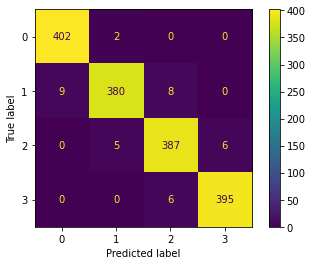

In [194]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline_best, X_train, y_train)

In [236]:
X_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,y_true,y_pred
122,825.0,1.0,0.5,1.0,7.0,0.0,52.0,0.9,130.0,3.0,...,863.0,3534.0,10.0,4.0,6.0,0.0,1.0,0.0,3.0,3.0
1123,1729.0,1.0,2.1,1.0,1.0,0.0,12.0,0.9,186.0,1.0,...,1178.0,1519.0,9.0,4.0,5.0,1.0,0.0,1.0,1.0,1.0
326,1144.0,1.0,1.5,1.0,0.0,0.0,21.0,0.4,189.0,1.0,...,724.0,3252.0,16.0,0.0,8.0,0.0,0.0,0.0,2.0,2.0
462,1986.0,0.0,0.5,1.0,3.0,1.0,51.0,0.1,165.0,8.0,...,1358.0,1614.0,17.0,12.0,3.0,1.0,1.0,1.0,1.0,1.0
773,1760.0,0.0,1.9,0.0,1.0,1.0,50.0,0.8,198.0,1.0,...,1704.0,2549.0,10.0,8.0,4.0,1.0,1.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852,648.0,1.0,1.8,0.0,1.0,1.0,60.0,0.1,195.0,4.0,...,1811.0,819.0,10.0,3.0,4.0,1.0,0.0,0.0,0.0,0.0
1333,1972.0,0.0,2.9,0.0,9.0,0.0,14.0,0.4,196.0,7.0,...,952.0,1316.0,8.0,1.0,8.0,1.0,1.0,0.0,1.0,1.0
335,803.0,0.0,0.8,1.0,0.0,0.0,18.0,0.3,106.0,4.0,...,935.0,2801.0,18.0,15.0,12.0,0.0,1.0,0.0,2.0,2.0
220,850.0,1.0,1.6,1.0,6.0,1.0,29.0,0.5,133.0,5.0,...,642.0,593.0,19.0,17.0,10.0,1.0,0.0,1.0,0.0,0.0


In [259]:
X_train[
    (X_train['y_true'] != X_train['y_pred'])
    & (X_train['y_true'] == 3)
]['ram']

322     3059.0
457     2982.0
26      3763.0
1184    3033.0
52      3112.0
177     2478.0
1527    2294.0
1999    3919.0
108     3029.0
436     3210.0
1907    3568.0
1772    2967.0
Name: ram, dtype: float64

In [195]:
log_reg_coef = pipeline_best.named_steps['log_reg'].coef_
feature_names = np.array([num_std_cols + num_robust_cols + ctg_cols])

df_coef0 = pd.DataFrame({
    'name': feature_names[0],
    'coef': log_reg_coef[0]
}).sort_values(by='coef')

df_coef1 = pd.DataFrame({
    'name': feature_names[0],
    'coef': log_reg_coef[1]
}).sort_values(by='coef')

df_coef2 = pd.DataFrame({
    'name': feature_names[0],
    'coef': log_reg_coef[2]
}).sort_values(by='coef')

df_coef3 = pd.DataFrame({
    'name': feature_names[0],
    'coef': log_reg_coef[3]
}).sort_values(by='coef')

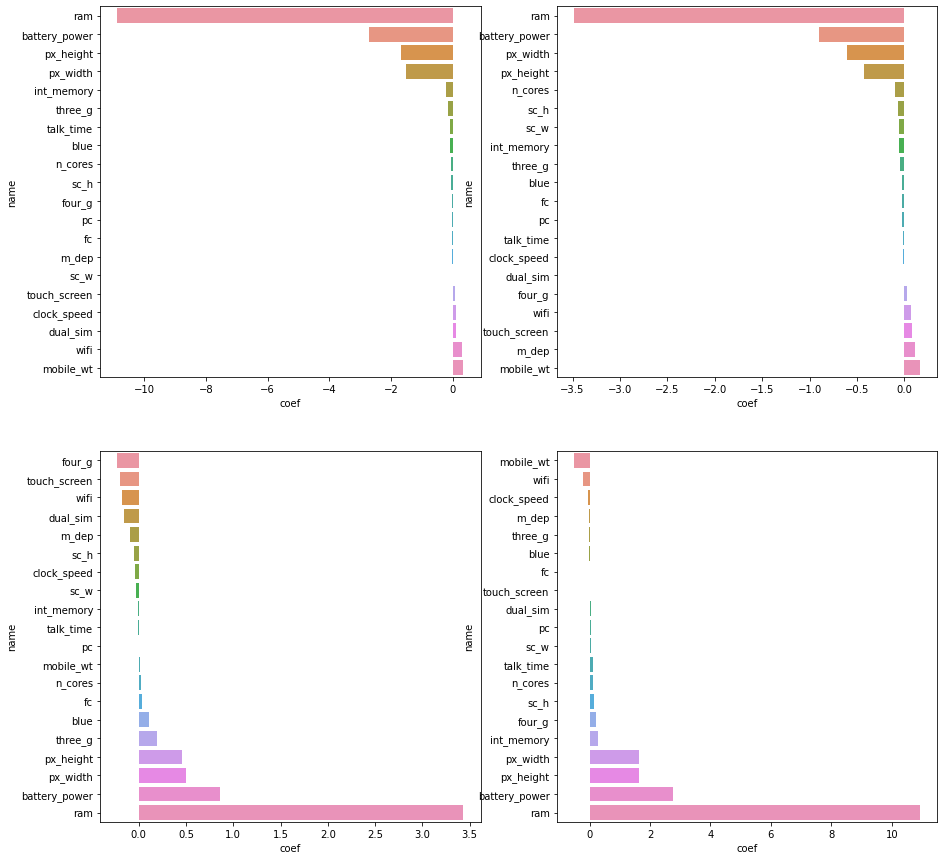

In [196]:
fig, axes = plt.subplots(2, 2, figsize=(15,15))
sns.barplot(data=df_coef0,x='coef',y='name', ax=axes.flatten()[0]);
sns.barplot(data=df_coef1,x='coef',y='name', ax=axes.flatten()[1]);
sns.barplot(data=df_coef2,x='coef',y='name', ax=axes.flatten()[2]);
sns.barplot(data=df_coef3,x='coef',y='name', ax=axes.flatten()[3]);

In [197]:
df_coef3

,name,coef
3,mobile_wt,-0.515719
19,wifi,-0.199817
9,clock_speed,-0.045225
2,m_dep,-0.013575
17,three_g,-0.004490
14,blue,-0.004258
10,fc,0.012881
18,touch_screen,0.028048
15,dual_sim,0.045515
5,pc,0.052894


In [254]:
all_list = []

for price in range(0, 4):
    for index in ['ram', 'battery_power', 'px_height', 'px_width']:
        all_list.append(df_mobile[df_mobile['price_range'] == price][index].mean())
        
np_all = np.array(all_list)
pd.DataFrame(np_all.reshape(4, 4), columns=['ram', 'battery_power', 'px_height', 'px_width'])

,ram,battery_power,px_height,px_width
0,785.314,1116.902,536.408,1150.270
1,1679.490,1228.868,666.892,1251.908
2,2582.816,1228.320,632.284,1234.046
3,3449.232,1379.984,744.848,1369.838


From the chart, we can see that features that have the most impact are:
- ram
- battery_power
- px_height, and
- px_width

By seeing the 4th chart (visualizing whether a phone will be classified into the most expensive category or not), we can see that with 1 unit increase of ram, the chances of the phone being classified as the most expensive increased by $ e^{10.9} $ times. We can also see that features such as fc (front camera megapixels) and blue (bluetooth availability) have little to no effect on the price

Average RAM of phones in the cheapest price is 785, while the most expensive is 3449.

Source: https://quantifyinghealth.com/interpret-logistic-regression-coefficients/